# IROP Project File

In [24]:
import numpy as np


#Generates N nodes and returns an array of tuples of their position.
def N_node_gen(N):
    node_list = list()
    for _ in range(N):
        node_list.append(np.array((np.random.random(), np.random.random())))
    return node_list

test_nodes = N_node_gen(5)
test_nodes

[array([0.49293655, 0.62777177]),
 array([0.94253801, 0.14970866]),
 array([0.21491643, 0.49225404]),
 array([0.39126367, 0.02156134]),
 array([0.15384761, 0.22971522])]

In [171]:
def original_adj_mat(node_list, R):
    N = len(node_list)
    adj_mat = np.zeros((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(i+1, N):
            dist = np.linalg.norm(node_list[i]-node_list[j])
            if dist < R:
                adj_mat[i, j] = 1
                adj_mat[j, i] = 1
    return adj_mat

In [172]:
def original_W_i_gen(i, adj_mat, gamma):
    i -= 1
    W_i = np.zeros(np.shape(adj_mat), dtype=np.float64)
    N = np.shape(adj_mat)[0]
    for j in range(N):
        if adj_mat[i, j]:
            W_i[j, j] = 1 - gamma
            W_i[j, i] = gamma
        else:
            W_i[j, j] = 1
    return W_i

In [173]:
def original_update_step(x, adj_mat, gamma):
    N = len(x)
    i = np.random.randint(N, size=1)
    W_i = original_W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

In [174]:
def original_simulate(x_0, adj_mat, gamma, time):
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(original_update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

## Generalisation to Weighted Graph

The following produces illustrations for weighted graphs with the following rule:

Suppose the euclidian distance between two nodes is $d < R$ then the weight between the two nodes is given by $1-\frac{d}{R}$ for $R$ the radius defined in the full set of notes. 

In [25]:
import numpy as np

#Returns adjacency matrix of the generated graph

def adj_mat_gen(node_list, R):
    N = len(node_list)
    adj_mat = np.zeros((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(i+1, N):
            dist = np.linalg.norm(node_list[i]-node_list[j])
            if dist < R:
                adj_mat[i, j] = 1 - dist/R
                adj_mat[j, i] = 1 - dist/R
    return adj_mat

test_adj_mat = adj_mat_gen(test_nodes, 0.5)

test_adj_mat

array([[0.        , 0.        , 0.3814202 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.3814202 , 0.        , 0.        , 0.        , 0.46090434],
       [0.        , 0.        , 0.        , 0.        , 0.36851152],
       [0.        , 0.        , 0.46090434, 0.36851152, 0.        ]])

In [26]:
#Produces the matrix W(i)

def W_i_gen(i, adj_mat, gamma):
    i -= 1
    W_i = np.zeros(np.shape(adj_mat), dtype=np.float64)
    N = np.shape(adj_mat)[0]
    for j in range(N):
        if adj_mat[i, j]:
            val = adj_mat[i, j].item()
            W_i[j, j] = 1 - gamma * val
            W_i[j, i] = gamma * val
        else:
            W_i[j, j] = 1
    return W_i

test_W_1 = W_i_gen(1, test_adj_mat, 0.5)

test_W_1

array([[1.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 1.       , 0.       , 0.       , 0.       ],
       [0.1907101, 0.       , 0.8092899, 0.       , 0.       ],
       [0.       , 0.       , 0.       , 1.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 1.       ]])

In [27]:
#A single step of the simulation

def update_step(x, adj_mat, gamma):
    N = len(x)
    i = np.random.randint(N, size=1)
    W_i = W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

test_x = np.random.random(size=5)
update_step(test_x, test_adj_mat, 0.5)

array([0.46823338, 0.96327913, 0.4304415 , 0.80501569, 0.72981842])

In [151]:
import numpy as np

def simulate(x_0, adj_mat, gamma, time):
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

test_x = np.random.random(size=5)
test_simulation = simulate(test_x, test_adj_mat, 0.5, 10)
test_simulation

array([[0.94605854, 0.91809298, 0.45222248, 0.86892417, 0.11735111],
       [0.94605854, 0.91809298, 0.45222248, 0.86892417, 0.11735111],
       [0.94605854, 0.91809298, 0.37505065, 0.73044251, 0.11735111],
       [0.94605854, 0.91809298, 0.31566323, 0.61747689, 0.11735111],
       [0.94605854, 0.91809298, 0.31566323, 0.61747689, 0.20950217],
       [0.94605854, 0.91809298, 0.43588598, 0.61747689, 0.20950217],
       [0.84876348, 0.91809298, 0.43588598, 0.61747689, 0.26167281],
       [0.77002357, 0.91809298, 0.43588598, 0.61747689, 0.30182061],
       [0.77002357, 0.91809298, 0.43588598, 0.61747689, 0.30182061],
       [0.77002357, 0.91809298, 0.43588598, 0.61747689, 0.3599821 ],
       [0.77002357, 0.91809298, 0.4996094 , 0.61747689, 0.3599821 ]])

In [ ]:
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000
gamma = 0.5
sim_num = 1000

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

x_0 = np.random.random(N)

In [152]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))
beta_matrix = np.identity(N) - 1/N * np.ones((N, N))
beta_arr = np.zeros((time+1, N), dtype=np.float64)

for _ in range(sim_num):
    output = simulate(x_0, adj_mat, gamma, time)
    x_array += output
    for i in range(t+1):
        beta_arr[i] += beta_matrix@output[i]

x_array /= sim_num
x_array -= desired_x

plot_vals = np.linalg.norm(x_array, axis=1)

plot_vals_2 = np.linalg.norm(beta_arr, axis=1)
plot_vals_2 /= sim_num

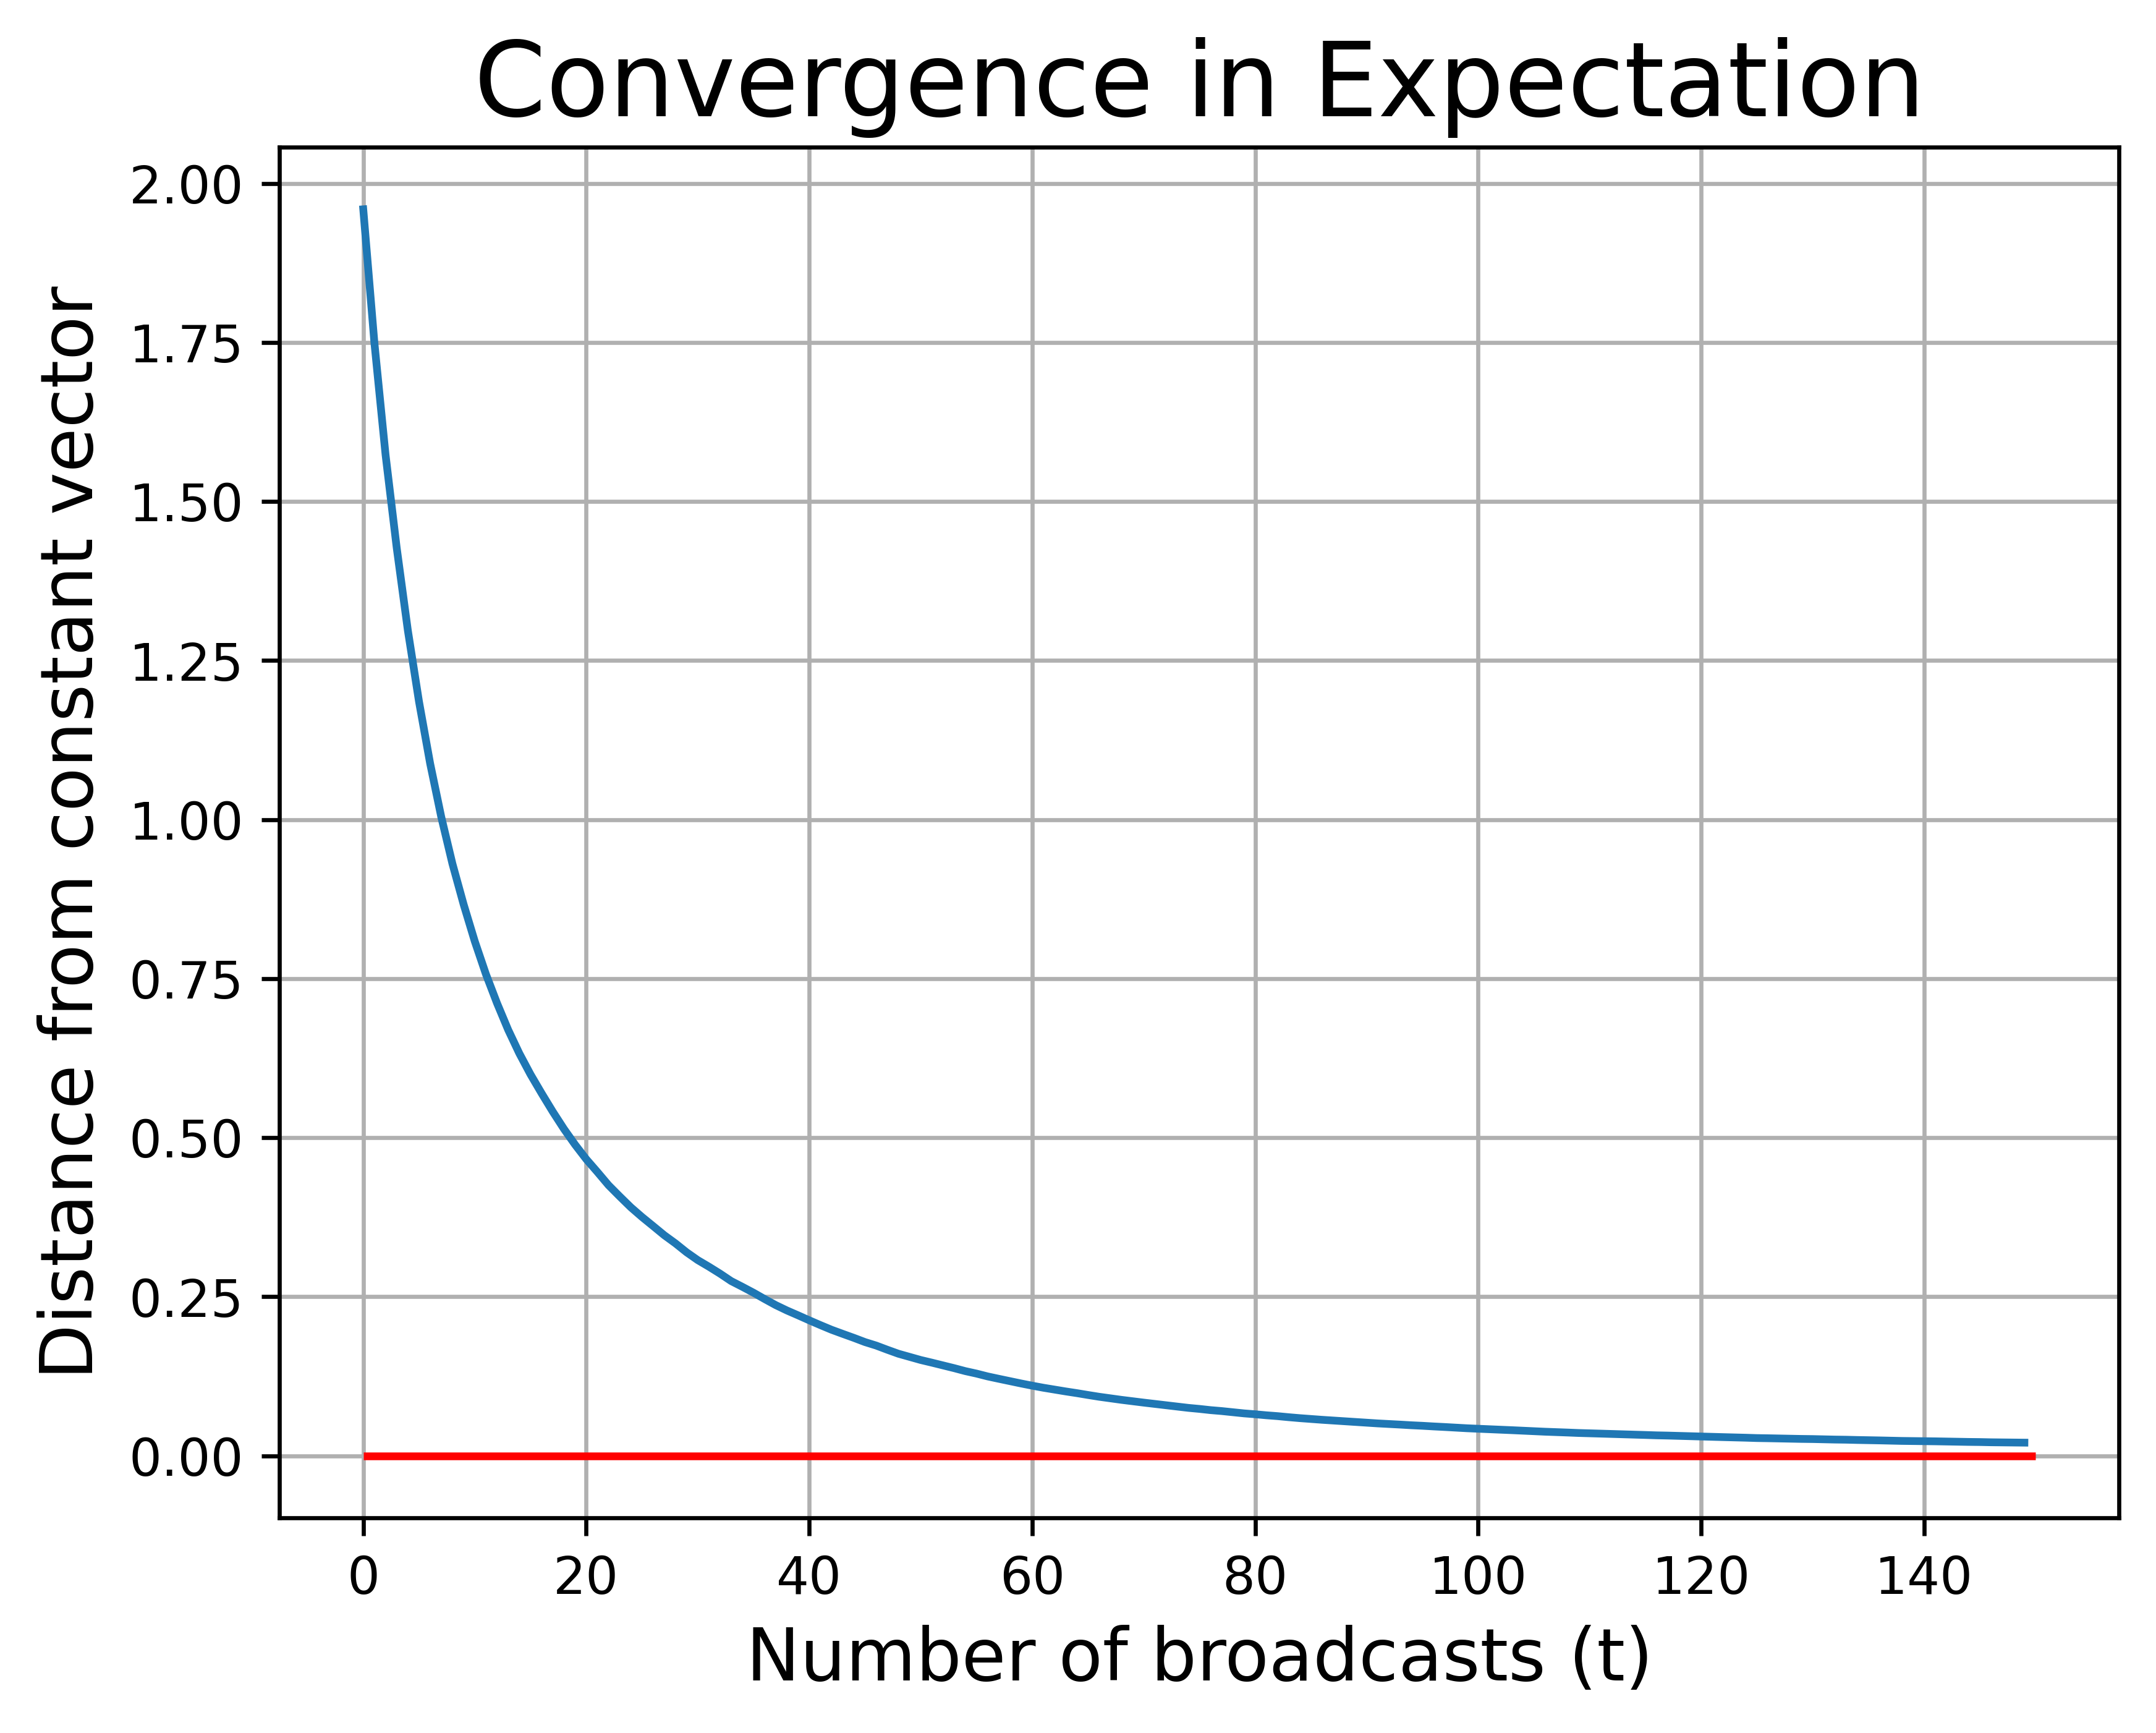

In [153]:
#Convergence in expectation plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:150], plot_vals[0:150])
ax.hlines(0, 0, 150, colors='r')
ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Distance from constant vector", fontsize=14)
ax.set_title("Convergence in Expectation", fontsize=20)
fig.set_dpi(600)

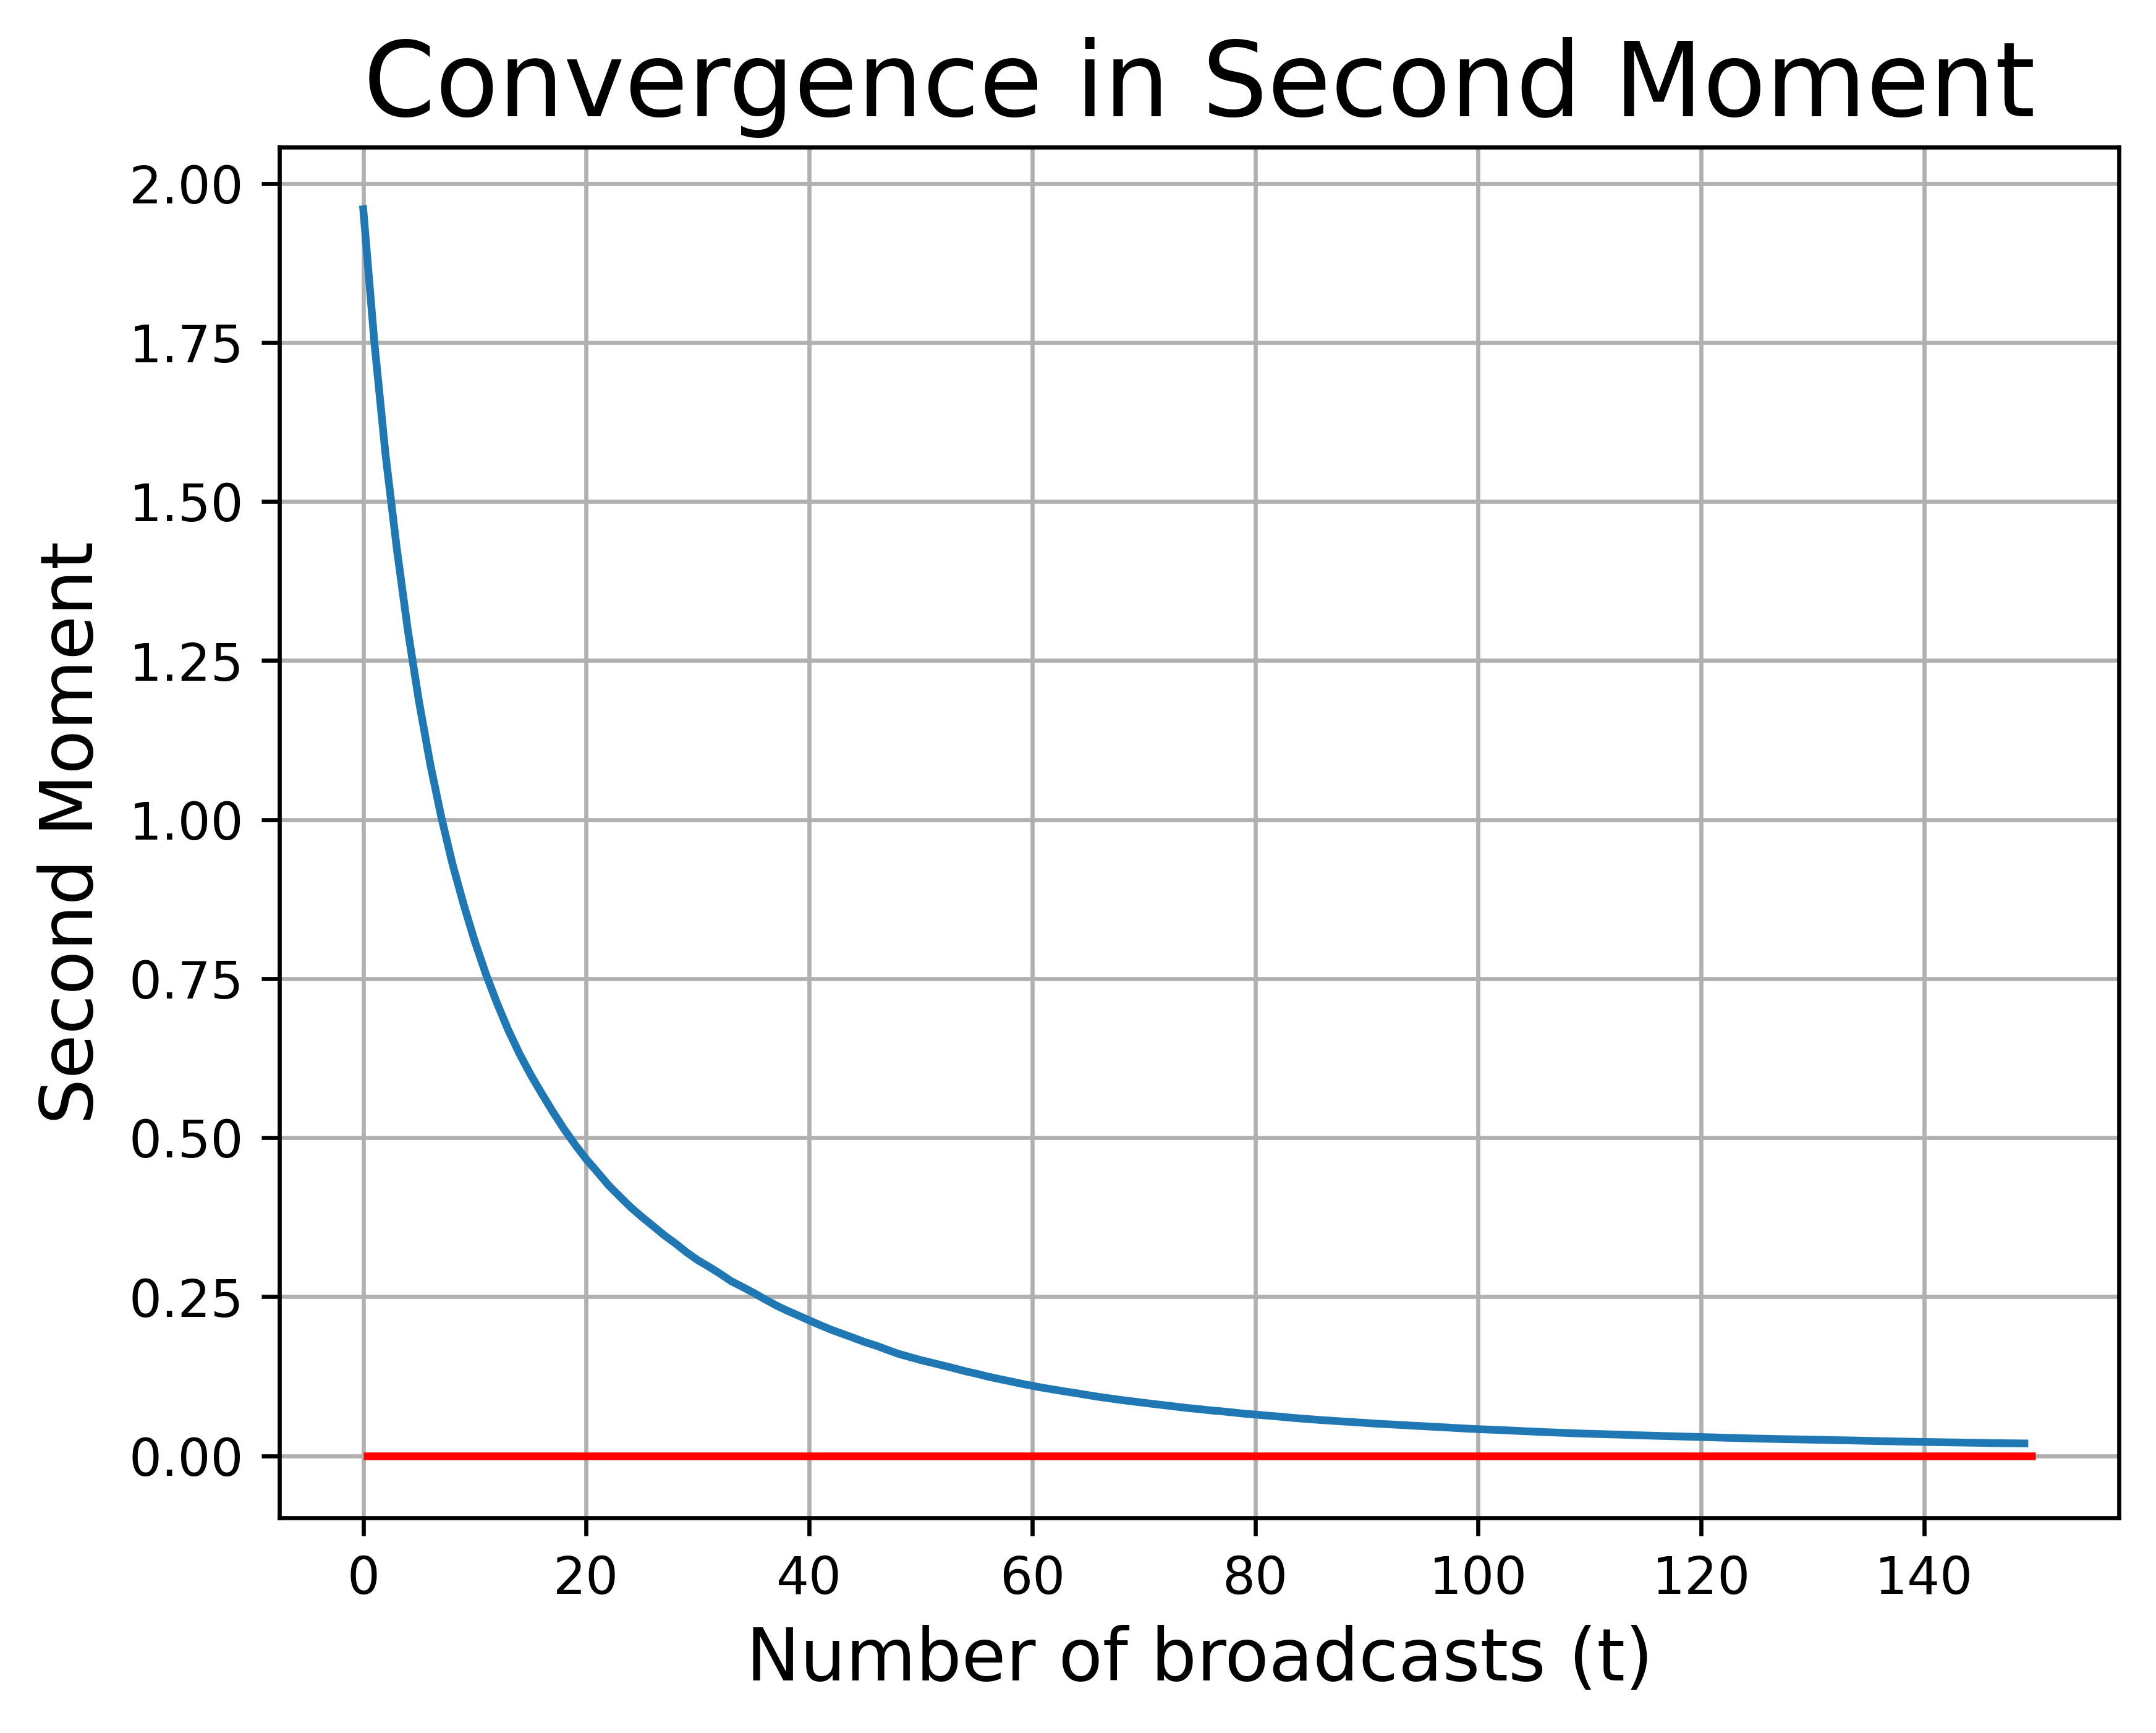

In [154]:
#Convergence in second moment plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:150], plot_vals_2[0:150])
ax.hlines(0, 0, 150, colors='r')

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Second Moment", fontsize=14)
ax.set_title("Convergence in Second Moment", fontsize=20)
fig.set_dpi(600)

## Generalisation to Stochastic Mixing Parameter

In [110]:
def indep_stoch_sim(x_0, adj_mat, gam, time):
    x_list = [x_0]
    for t in range(1, time+1):
        gamma = np.random.uniform(0, gam)
        x_list.append(update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

In [111]:
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000
gam = 1

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

x_0 = np.random.random(N)

In [165]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))
beta_matrix = np.identity(N) - 1/N * np.ones((N, N))
beta_arr = np.zeros((time+1, N), dtype=np.float64)

for _ in range(sim_num):
    output = indep_stoch_sim(x_0, adj_mat, gam, time)
    x_array += output
    for i in range(t+1):
        beta_arr[i] += beta_matrix@output[i]

x_array /= sim_num
x_array -= desired_x

plot_vals_indep_1 = np.linalg.norm(x_array, axis=1)

plot_vals_indep_2 = np.linalg.norm(beta_arr, axis=1)
plot_vals_indep_2 /= sim_num


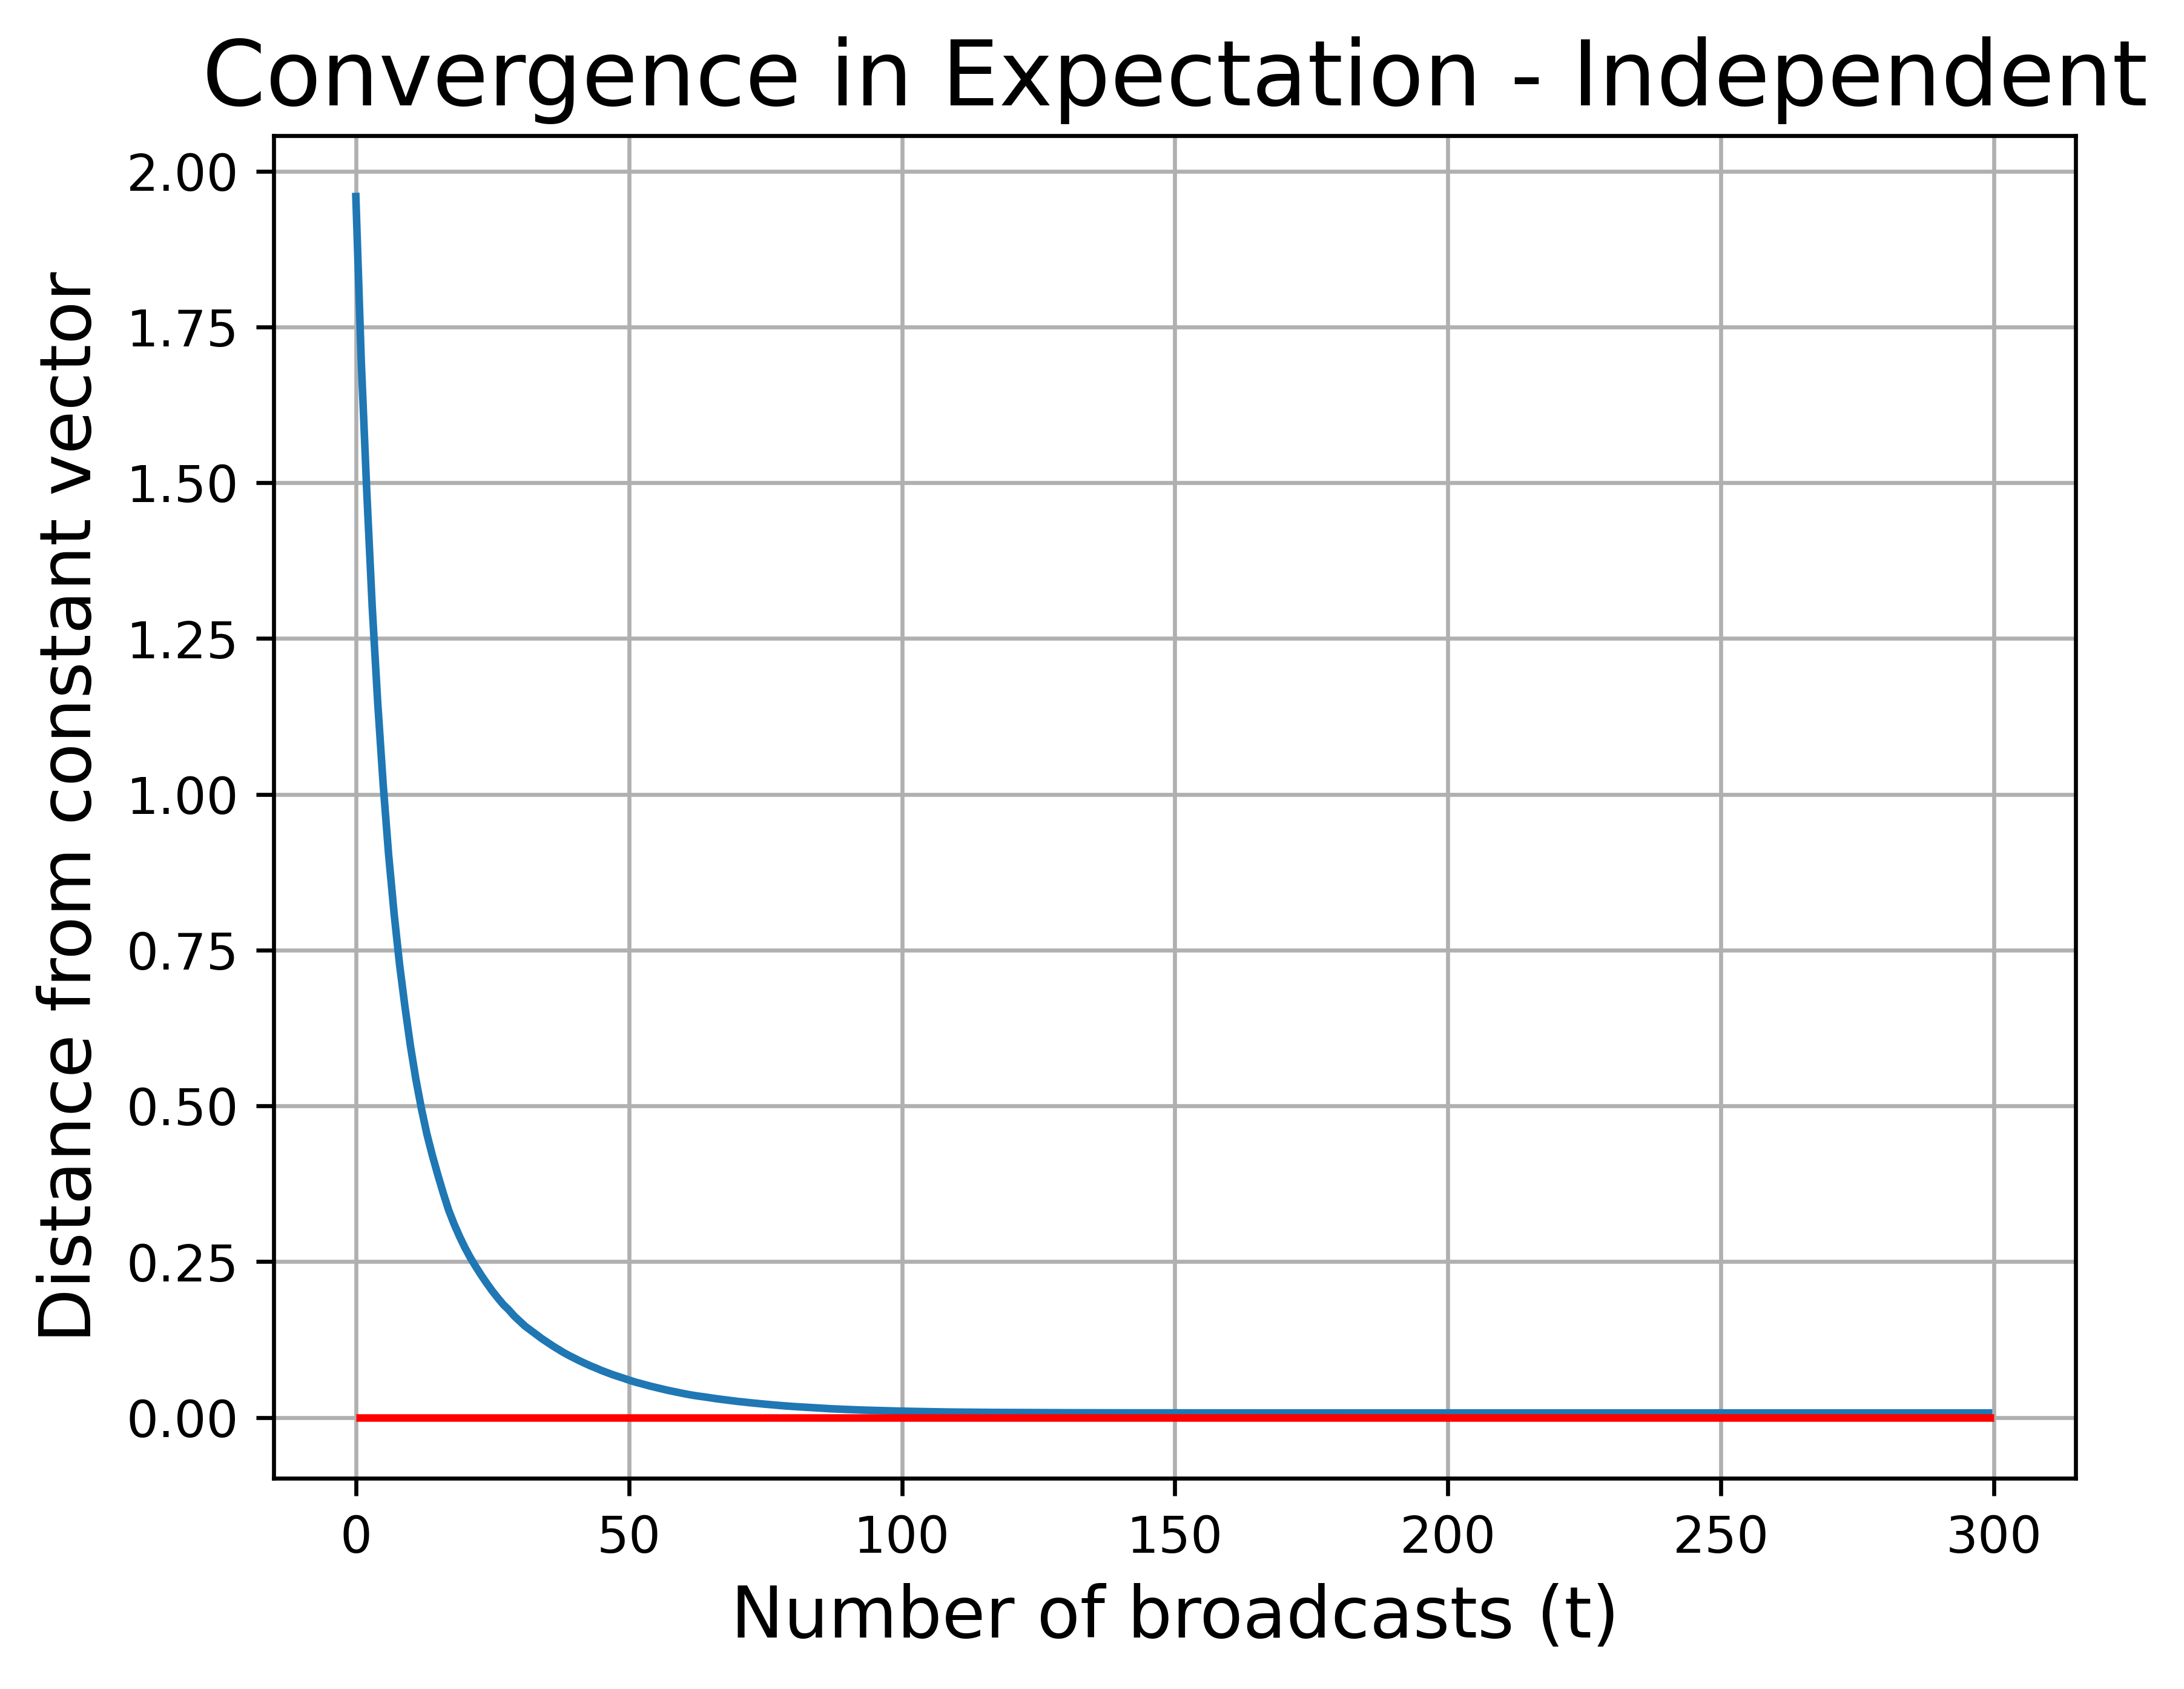

In [166]:
# Convergence in expectation plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_indep_1[0:300])
ax.hlines(0, 0, 300, colors='r')
ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Distance from constant vector", fontsize=14)
ax.set_title("Convergence in Expectation - Independent", fontsize=18)
fig.set_dpi(600)

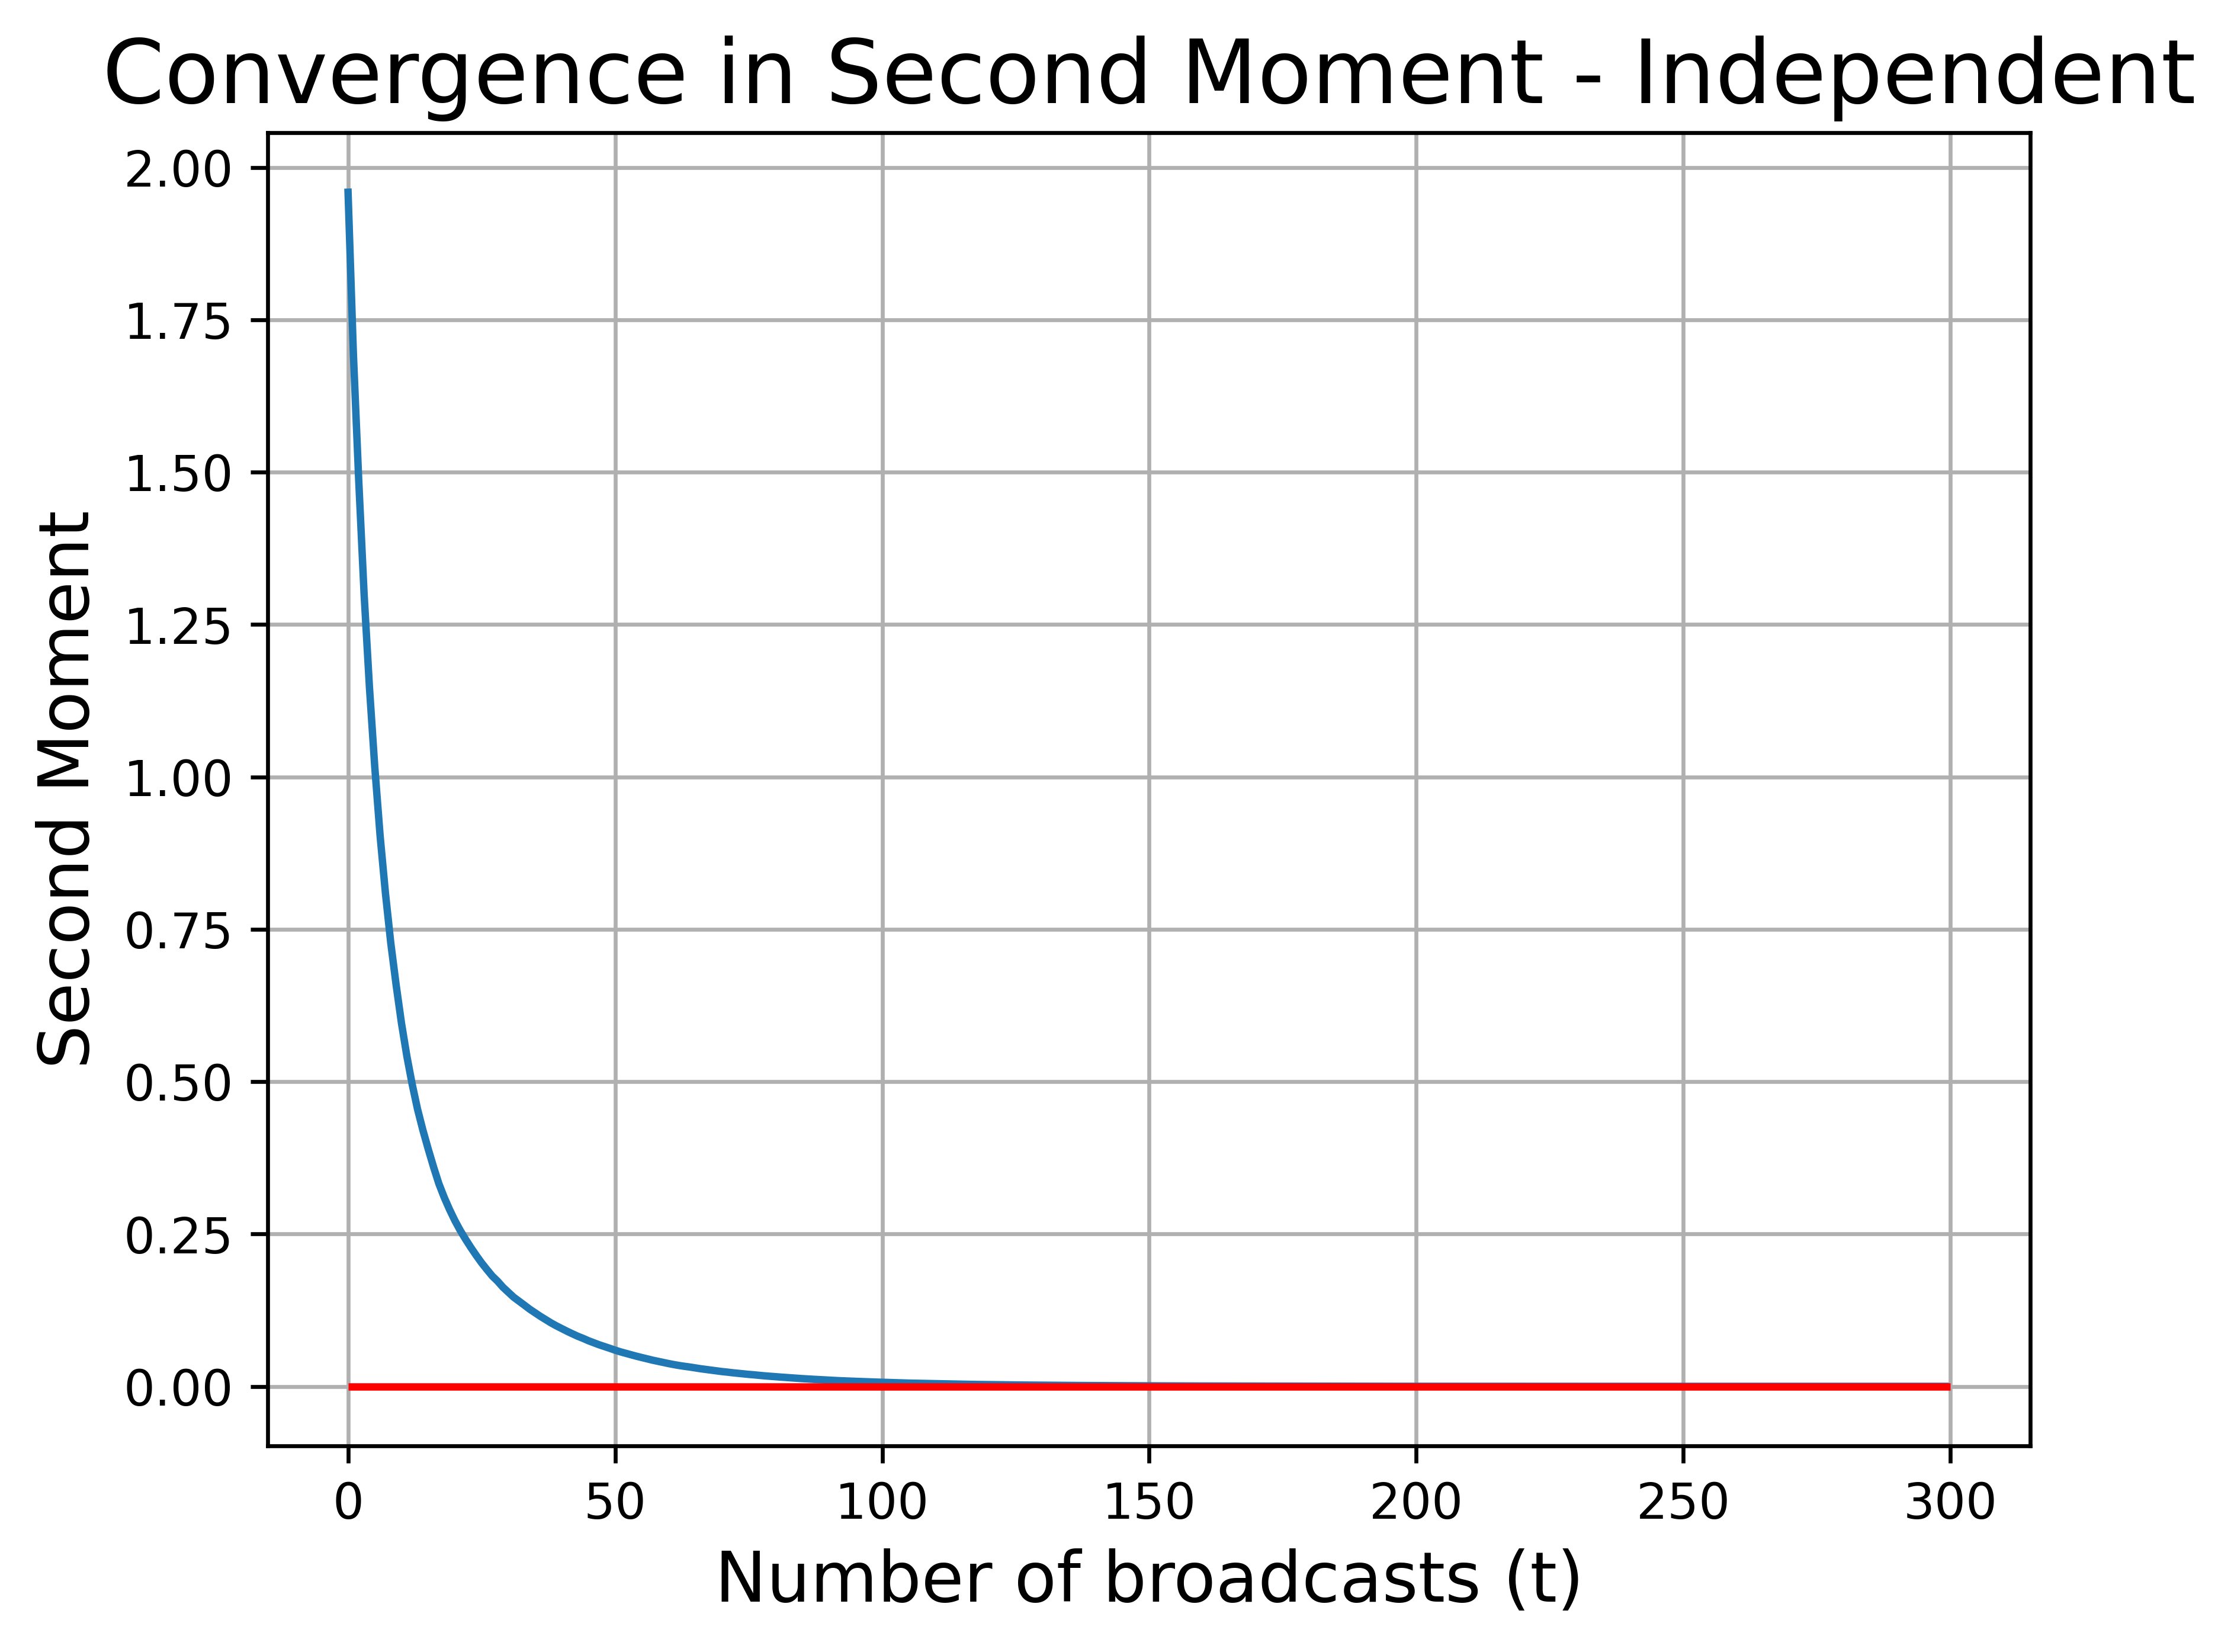

In [167]:
#Convergence in second moment plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_indep_2[0:300])
ax.hlines(0, 0, 300, colors='r')

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Second Moment", fontsize=14)
ax.set_title("Convergence in Second Moment - Independent", fontsize=18)
fig.set_dpi(600)

## Generalisation to Dependent Stochastic Mixing Parameter

In [133]:
#A single step of the simulation

def dep_update_step(x, adj_mat, gam_dict):
    N = len(x)
    i = np.random.randint(N, size=1)
    gamma = np.random.uniform(0, gam_dict[i[0]])
    W_i = W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

In [132]:
import numpy as np

def dep_stoch_sim(x_0, adj_mat, gam_dict, time):
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(dep_update_step(x_list[-1], adj_mat, gam_dict))
    return np.array(x_list)

In [209]:
import networkx as nx

sim_num = 1000
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

G = nx.from_numpy_array(adj_mat)
gam_dict = nx.pagerank(G)

maxval = max(gam_dict.values())
gam_dict = {key: value/maxval for key, value in gam_dict.items()}

x_0 = np.random.random(N)

gam_dict

{0: 0.451713687122552,
 1: 0.9178208236779198,
 2: 0.44371974364992717,
 3: 0.809769733753481,
 4: 0.5265935722397619,
 5: 0.6250706716495634,
 6: 0.42509689824826236,
 7: 0.6262426097005793,
 8: 1.0,
 9: 0.95883879929842,
 10: 0.5615748653863972,
 11: 0.7096130451662996,
 12: 0.49201945621229554,
 13: 0.6908055929056881,
 14: 0.5187287001665989,
 15: 0.6085670305274915,
 16: 0.7516699954236434,
 17: 0.842667793634358,
 18: 0.4648946235907777,
 19: 0.5764836537274308,
 20: 0.5932632214546839,
 21: 0.5356049998980827,
 22: 0.7356025062302105,
 23: 0.8829194415409338,
 24: 0.8636194962728537,
 25: 0.6035918130025749,
 26: 0.8816358263977422,
 27: 0.8705426363190127,
 28: 0.6932535274269136,
 29: 0.86197988892902,
 30: 0.7295483522887061,
 31: 0.9015047074840642,
 32: 0.4066083389938534,
 33: 0.9311411670542077,
 34: 0.664723770396542,
 35: 0.4501152521272142,
 36: 0.8968942117541989,
 37: 0.8136616808360672,
 38: 0.9972368217116163,
 39: 0.5704289383579503,
 40: 0.8297444339513445,
 41: 

In [210]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))
beta_matrix = np.identity(N) - 1/N * np.ones((N, N))
beta_arr = np.zeros((t+1, N), dtype=np.float64)

for _ in range(sim_num):
    output = dep_stoch_sim(x_0, adj_mat, gam_dict, time)
    x_array += output
    for i in range(t+1):
        beta_arr[i] += beta_matrix@output[i]

x_array /= sim_num
x_array -= desired_x

plot_vals_dep_1 = np.linalg.norm(x_array, axis=1)

plot_vals_dep_2 = np.linalg.norm(beta_arr, axis=1)
plot_vals_dep_2 /= sim_num


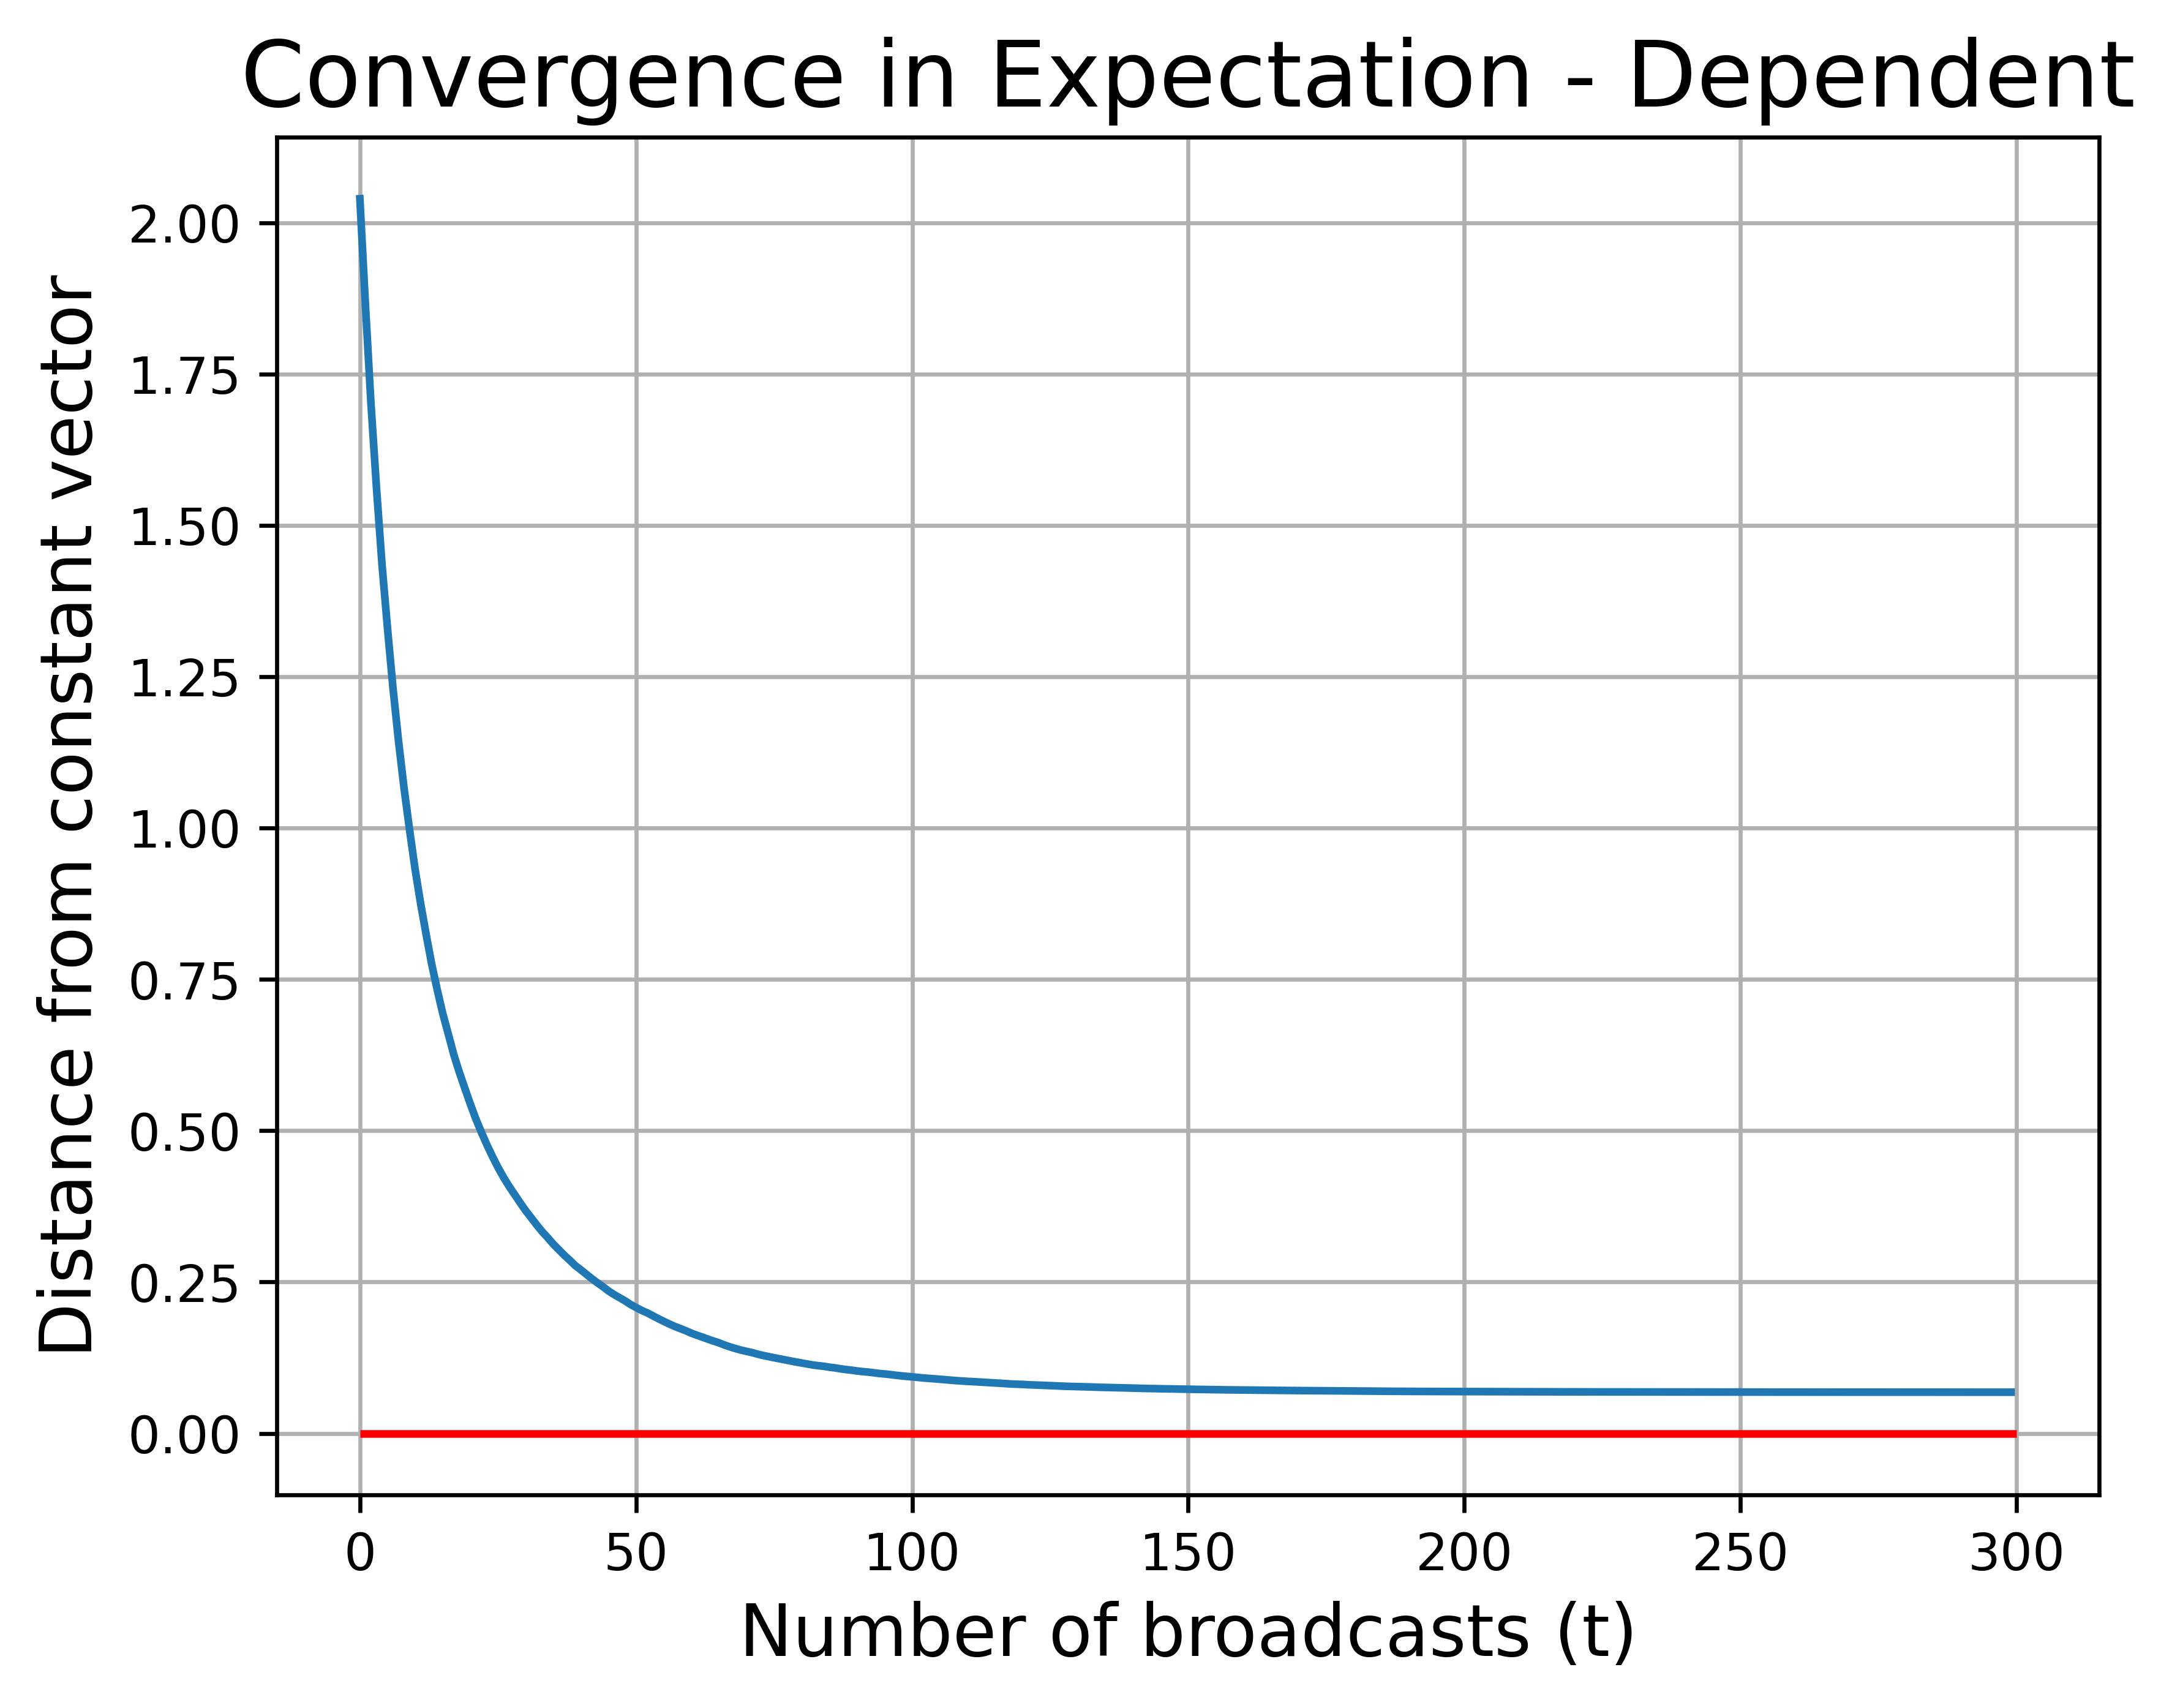

In [211]:
# Convergence in expectation plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_dep_1[0:300])
ax.hlines(0, 0, 300, colors='r')
ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Distance from constant vector", fontsize=14)
ax.set_title("Convergence in Expectation - Dependent", fontsize=18)
fig.set_dpi(600)

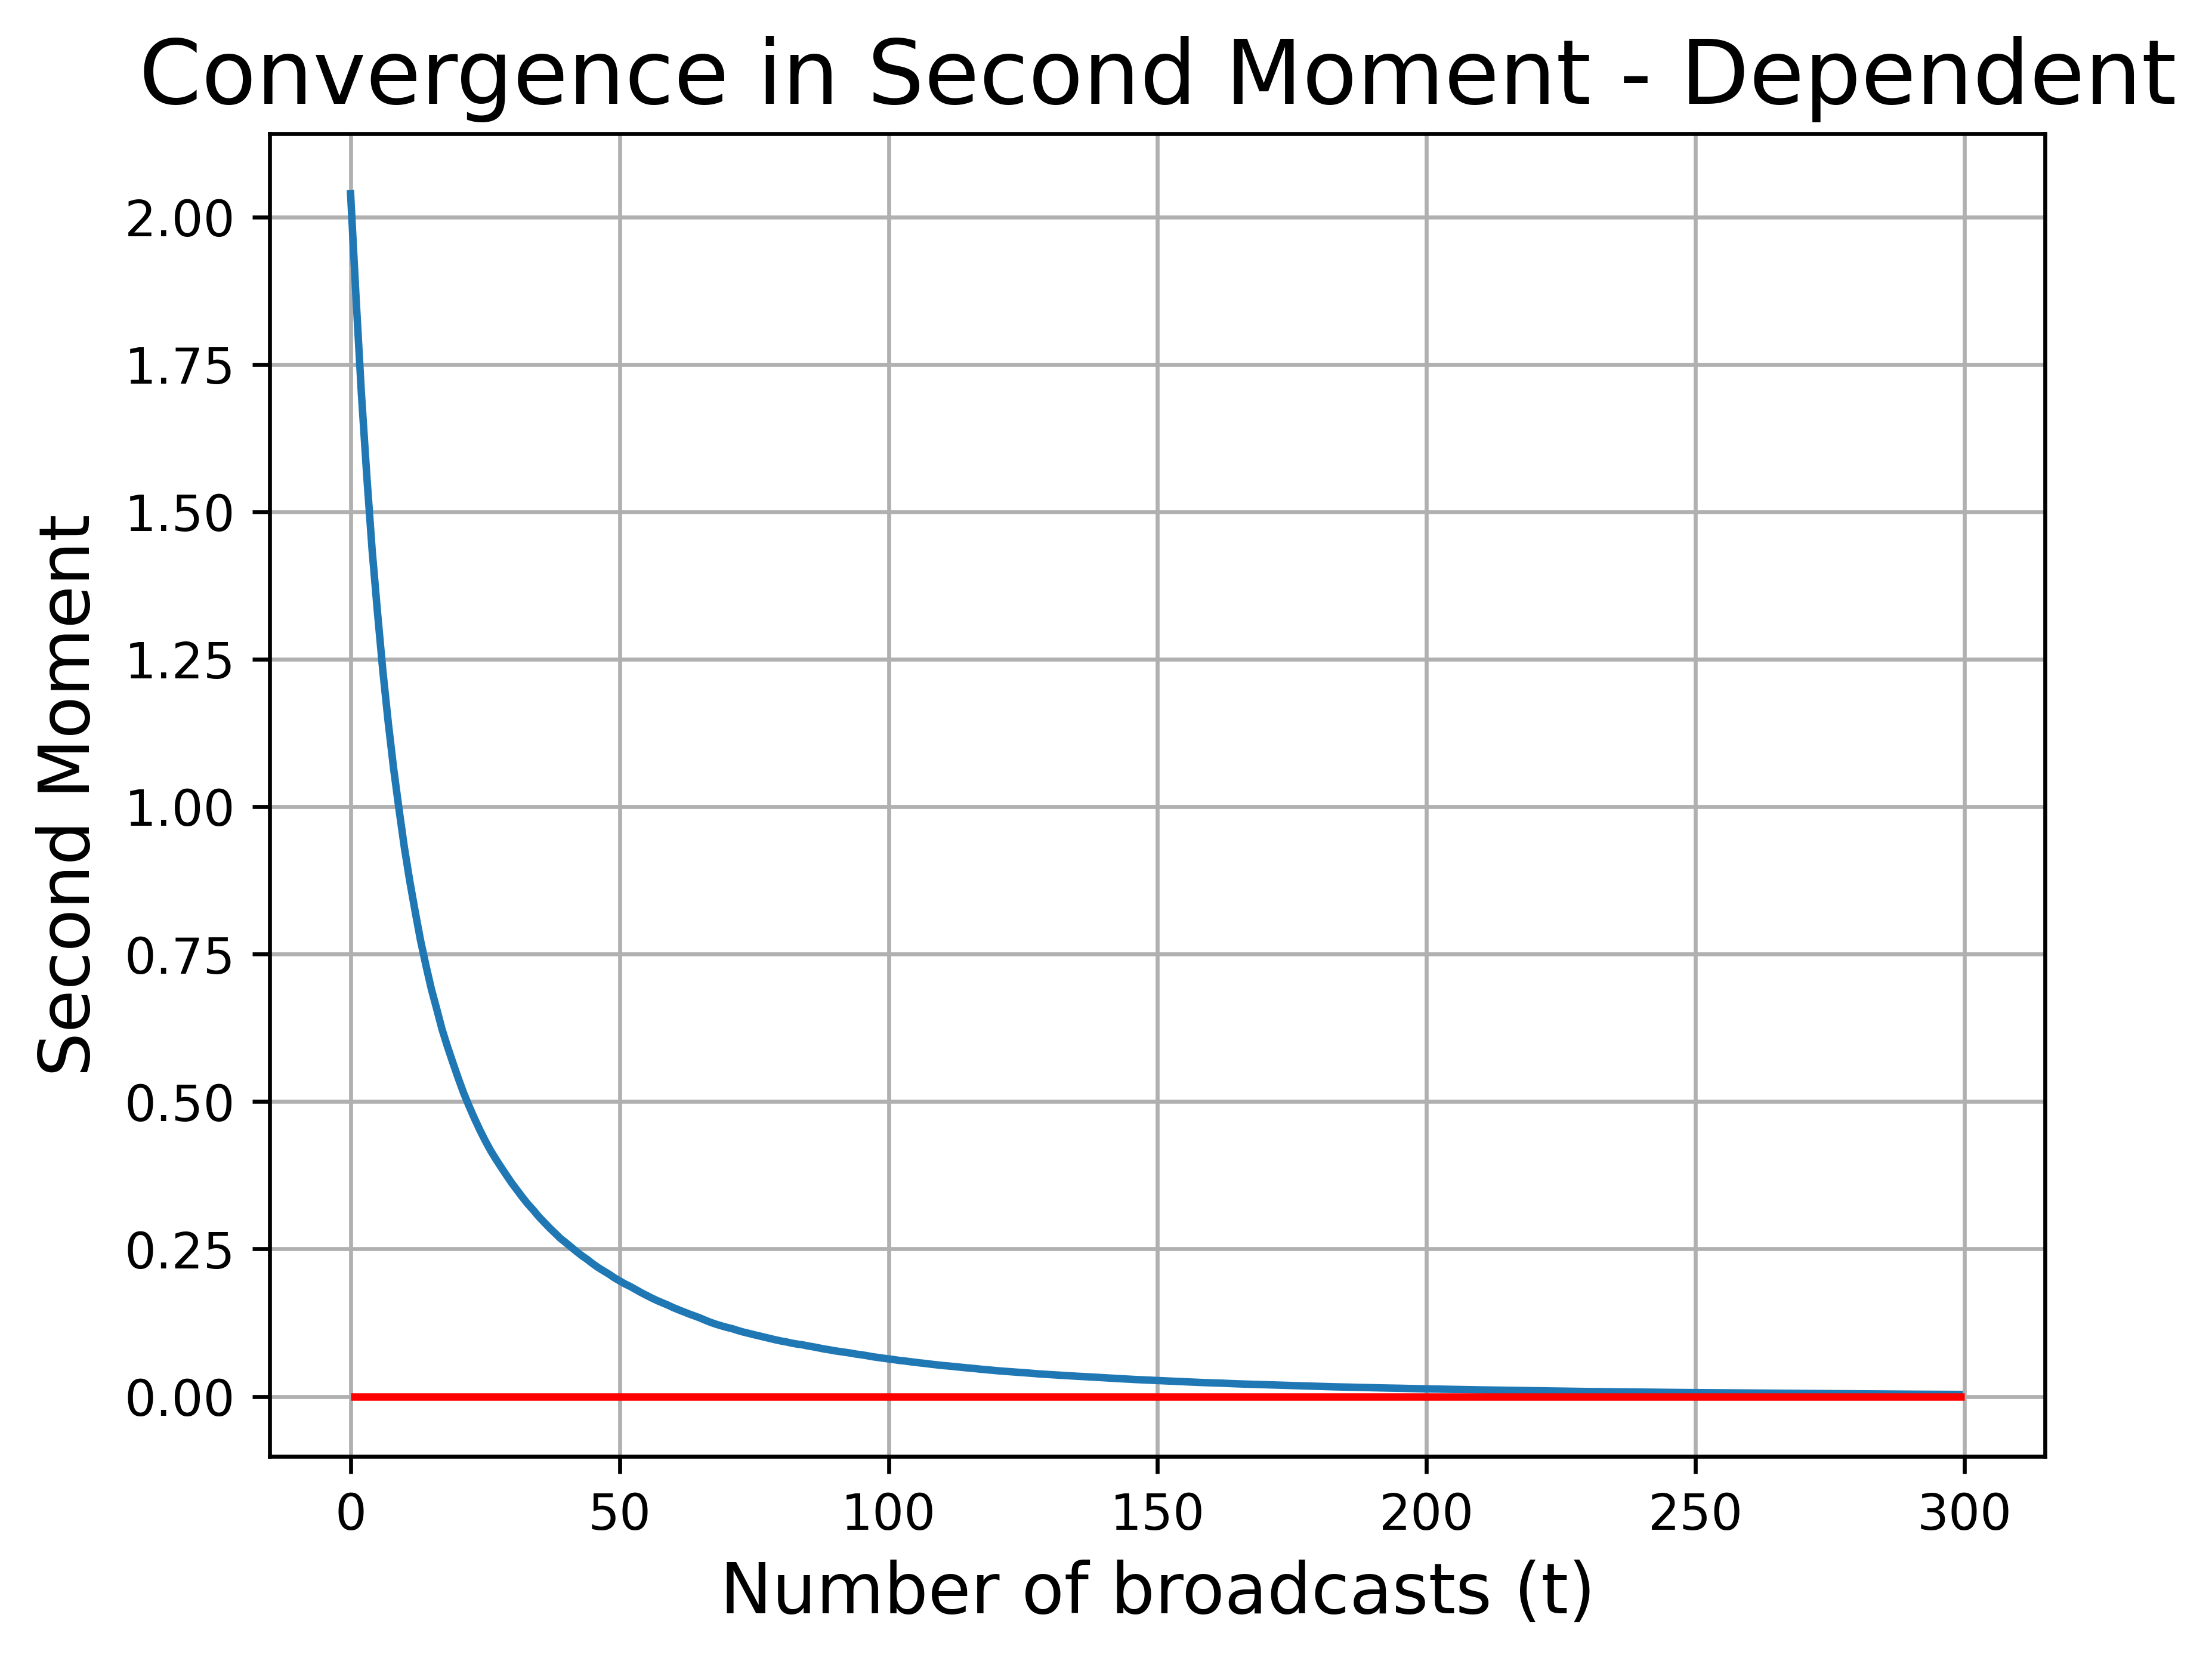

In [212]:
#Convergence in second moment plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_dep_2[0:300])
ax.hlines(0, 0, 300, colors='r')

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Second Moment", fontsize=14)
ax.set_title("Convergence in Second Moment - Dependent", fontsize=18)
fig.set_dpi(600)

## Communication Cost Study

In [213]:
N = 50
R = np.sqrt(np.log(N)/N)
time = 1000
gam = 1
gamma = 0.5

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

G = nx.from_numpy_array(adj_mat)
gam_dict = nx.pagerank(G)

maxval = max(gam_dict.values())
gam_dict = {key: value/maxval for key, value in gam_dict.items()}

x_0 = np.random.random(N)

In [216]:
#The following generates data for investigating communication cost

import numpy as np

k = 15

steps = np.arange(100, k*100+1, 100)
per_node_var_original = np.zeros(steps.shape, dtype=np.longdouble)
per_node_var_weighted = np.zeros(steps.shape, dtype=np.longdouble)
per_node_var_indep = np.zeros(steps.shape, dtype=np.longdouble)
per_node_var_dep = np.zeros(steps.shape, dtype=np.longdouble)

x_0 = np.random.random(N)
J = 1/N * np.ones((N, N))

for _ in range(0, 100):
    for i in range(0, k):
        output = original_simulate(x_0, adj_mat, gamma, steps[i])[-1]
        per_node_var_original[i] +=np.linalg.norm(output - J @ output)**2 / N
        output_1 = simulate(x_0, adj_mat, gamma, steps[i])[-1]
        per_node_var_weighted[i] += np.linalg.norm(output_1 - J @ output_1)**2 / N
        output_2 = indep_stoch_sim(x_0, adj_mat, gam, steps[i])[-1]
        per_node_var_indep[i] += np.linalg.norm(output_2 - J @ output_2)**2 / N
        output_3 = dep_stoch_sim(x_0, adj_mat, gam_dict, steps[i])[-1]
        per_node_var_dep[i] += np.linalg.norm(output_3 - J @ output_3)**2 / N

per_node_var_original /= 100
per_node_var_weighted /= 100
per_node_var_indep /= 100
per_node_var_dep /= 100

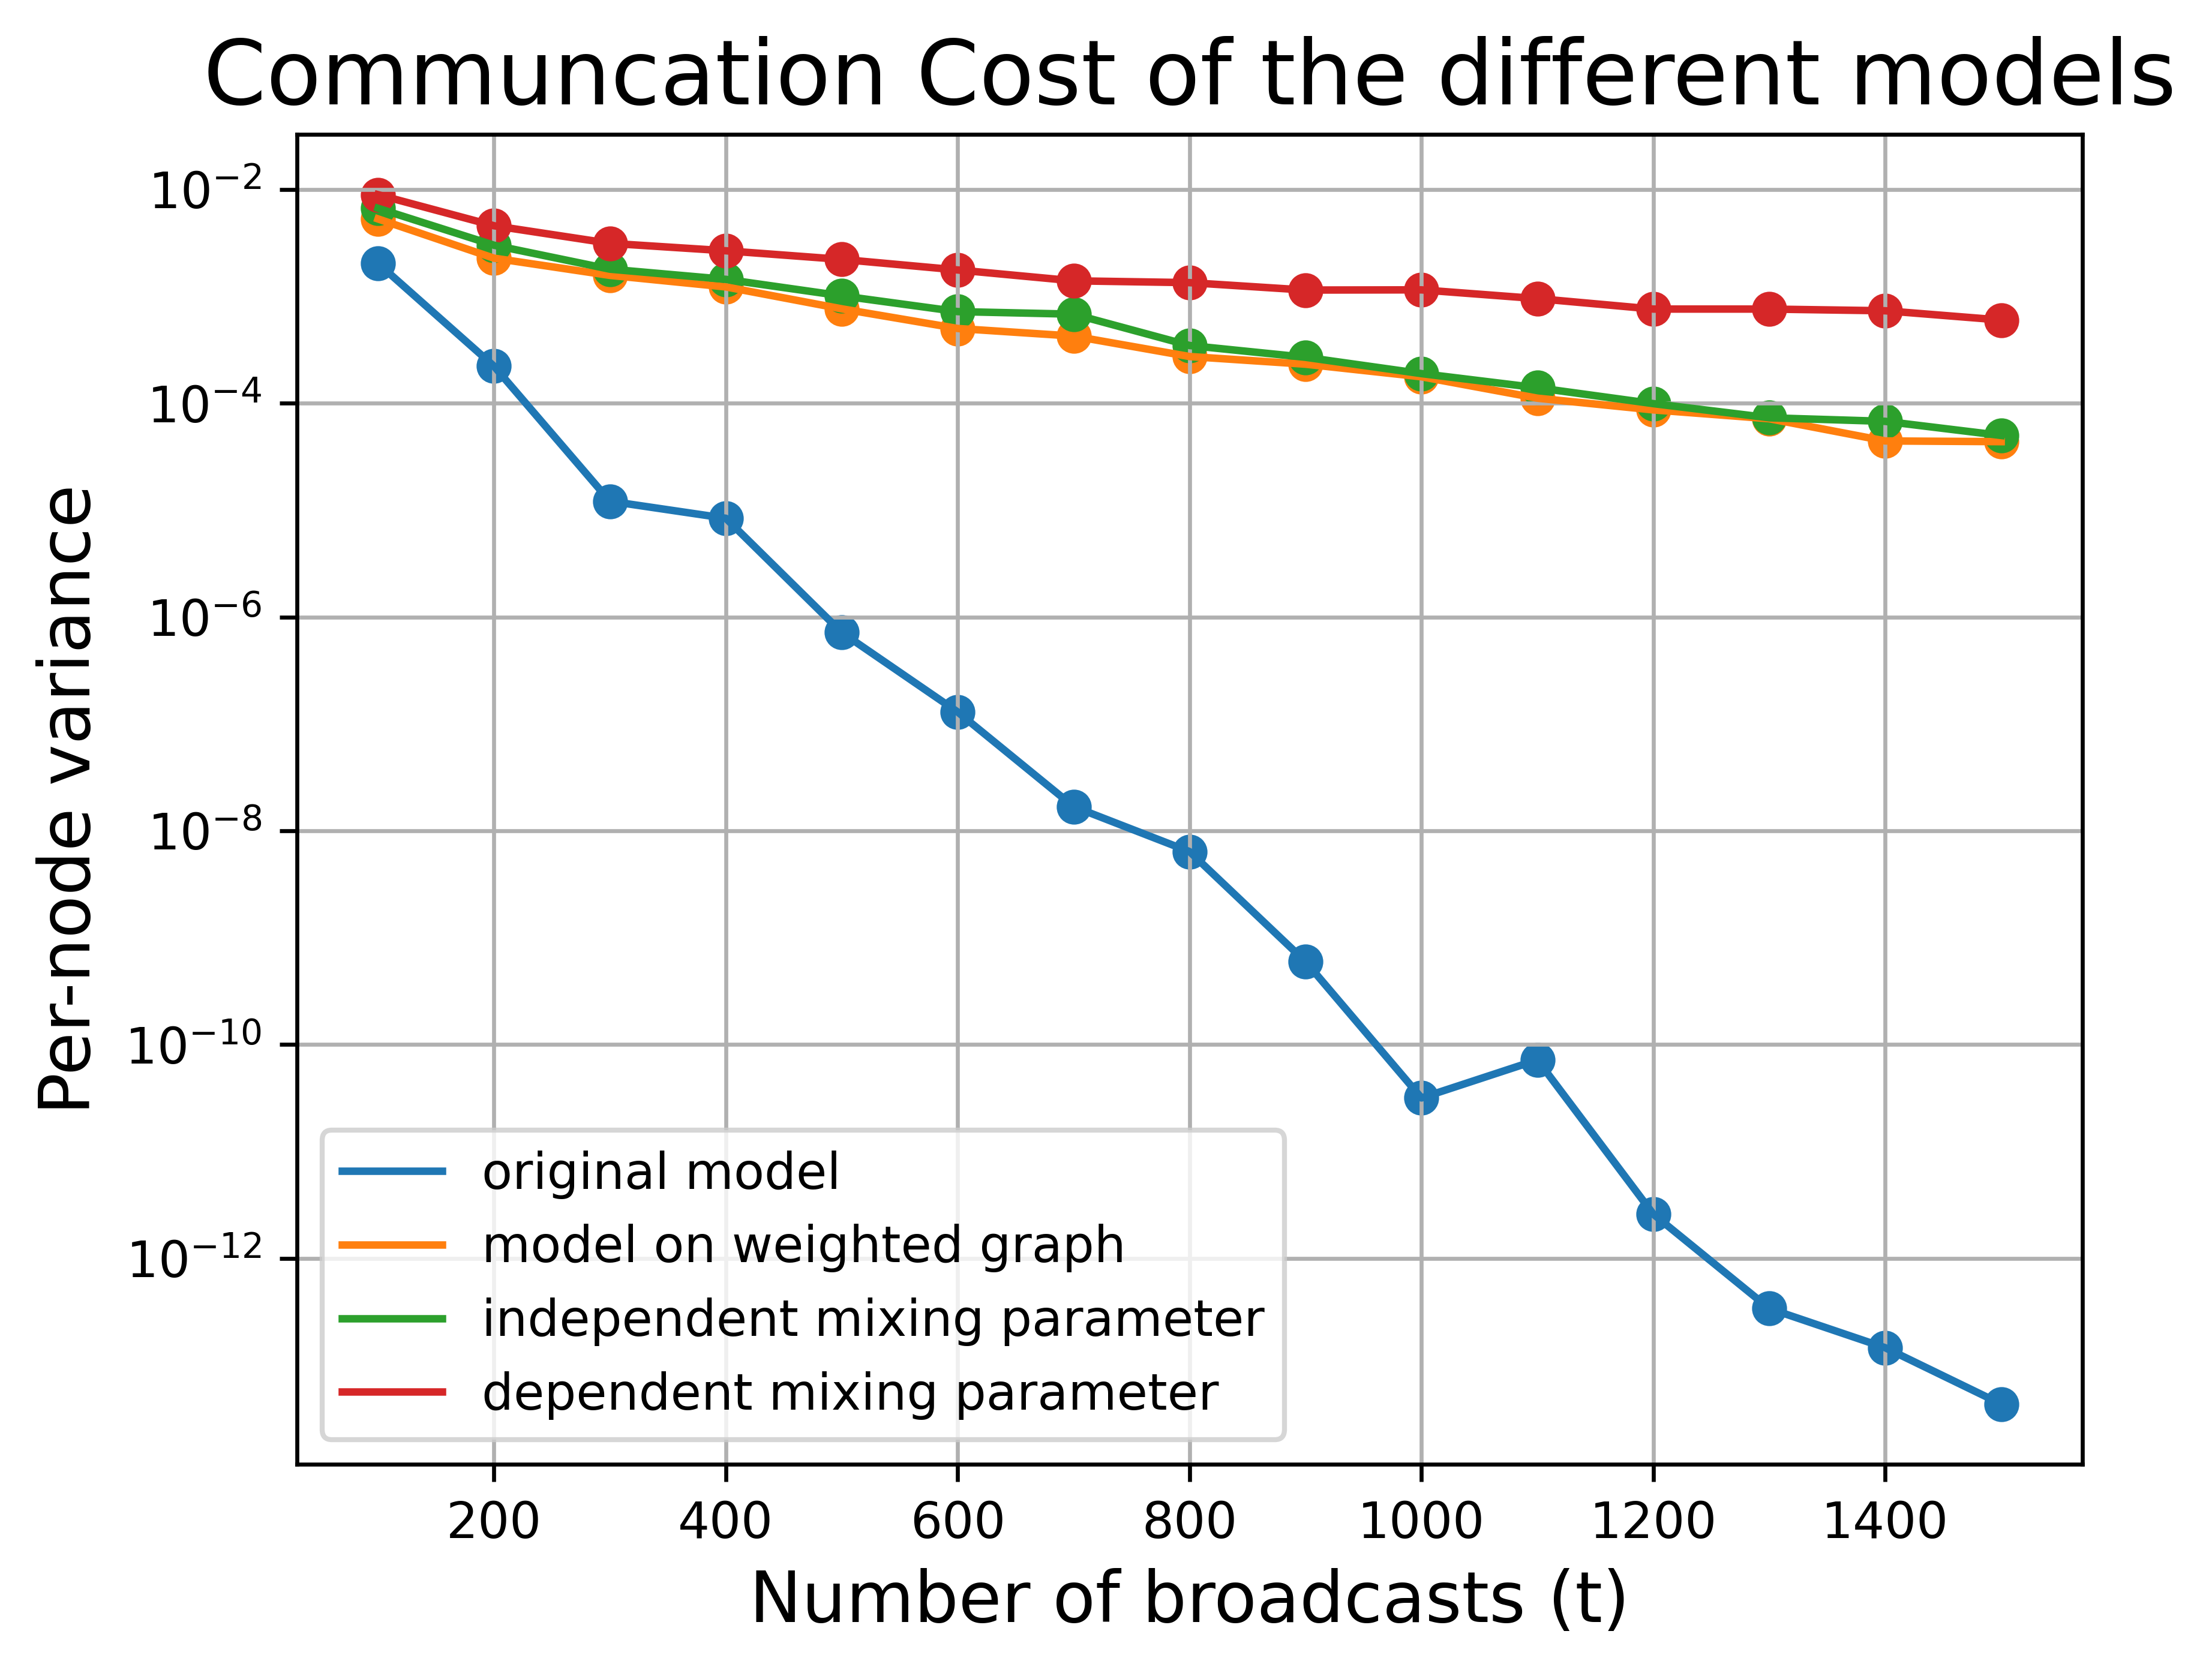

In [217]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.semilogy(steps, per_node_var_original, label="original model")
ax.scatter(steps, per_node_var_original)

ax.semilogy(steps, per_node_var_weighted, label="model on weighted graph")
ax.scatter(steps, per_node_var_weighted)

ax.semilogy(steps, per_node_var_indep, label="independent mixing parameter")
ax.scatter(steps, per_node_var_indep)

ax.semilogy(steps, per_node_var_dep, label = "dependent mixing parameter")
ax.scatter(steps, per_node_var_dep)

ax.legend(fontsize=10)

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Per-node variance", fontsize=14)
ax.set_title("Communcation Cost of the different models", fontsize=18)

fig.set_dpi(600)